1. 関数定義

In [6]:
# =========================
# 1) 関数定義（6qubits・軽量VQA＋HAR実現系ラグ特徴）
# =========================
import os, re, math, time, warnings
from dataclasses import dataclass
from typing import Optional, Tuple, List, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, SparsePauliOp

# ---------- 出力先 ----------
OUTPUT_DIR = r"C:\qiskit-python\QFF2025\outputs\VQA"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def savefig_show(fname, dpi=300):
    path = os.path.join(OUTPUT_DIR, fname)
    plt.savefig(path, dpi=dpi, bbox_inches='tight')
    print(f"[SAVE] {path}")
    plt.show()
    plt.close()

def savecsv(df: pd.DataFrame, fname: str):
    path = os.path.join(OUTPUT_DIR, fname)
    df.to_csv(path, index=False)
    print(f"[SAVE] {path}")

# ---------- Estimator のバージョン分岐 ----------
ESTIMATOR_MODE = "SV"
_Estimator = None
try:
    # Qiskit 0.46+ の EstimatorV2
    from qiskit.primitives import Estimator as _Estimator
    ESTIMATOR_MODE = "V2"
except Exception:
    try:
        # Aer の Estimator(V1)
        from qiskit_aer.primitives import Estimator as _Estimator
        ESTIMATOR_MODE = "V1"
    except Exception:
        _Estimator = None
print(f"[ENV] estimator_mode = {ESTIMATOR_MODE} (V2=tuple, V1=split, SV=statevector)")

# ---------- データ読み込み ----------
def load_prices_csv(csv_path: str) -> Tuple[pd.DataFrame, pd.Series]:
    df = pd.read_csv(csv_path)
    # Date 列推定（末尾優先）
    date_col = None
    for c in df.columns[::-1]:
        if str(c).lower() == "date":
            date_col = c; break
    if date_col is None:
        date_col = df.columns[-1]
    dates = pd.to_datetime(df[date_col], errors='coerce', dayfirst=False, infer_datetime_format=True)
    prices = df.drop(columns=[date_col]).astype(float)
    return prices, dates

# 新: 添付ノートから読み込み関数を流用
from typing import Tuple, List, Dict, Optional
import pandas as pd, numpy as np, re, os

# === 引用元: QRC_Tomabechi_ver3 Cell 1 の実装を移植（多少リネーム） ===
HEADER_BIPAT = r"Tenor\s*:\s*([0-9.+\-eE]+)\s*;\s*Maturity\s*:\s*([0-9.+\-eE]+)"
TENOR_PAT   = r"Tenor\s*:\s*([0-9.+\-eE]+)(?=\s*;)"
MATU_PAT    = r"Maturity\s*:\s*([0-9.+\-eE]+)"

def read_swaption_csv_with_mask(csv_path: str):
    df = pd.read_csv(csv_path, engine="python", sep=None)
    date_col = next((c for c in df.columns[::-1] if str(c).strip().lower()=="date"), df.columns[-1])
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    feat_cols = [c for c in df.columns if c != date_col]
    df_num = df.copy()
    df_num[feat_cols] = df_num[feat_cols].apply(pd.to_numeric, errors="coerce")
    # 前後方埋めで欠損を払う（学習器手前でのNaN排除）
    df_num[feat_cols] = df_num[feat_cols].ffill().bfill()
    mask_obs = ~df_num[feat_cols].isna().values
    return df_num, date_col, feat_cols, mask_obs  # :contentReference[oaicite:2]{index=2}

def read_exog_features(exog_csv_path: str, date_col_name: str = "Date", drop_cols: List[str] = ("TARGET",)):
    if not os.path.exists(exog_csv_path):
        print(f"[INFO] exog file not found: {exog_csv_path} (skip)")
        return None
    ex = pd.read_csv(exog_csv_path)
    if date_col_name not in ex.columns:
        cand = [c for c in ex.columns if str(c).strip().lower()=="date"]
        date_col_name = cand[0] if cand else ex.columns[0]
    ex[date_col_name] = pd.to_datetime(ex[date_col_name], errors="coerce")
    for d in drop_cols:
        if d in ex.columns: ex = ex.drop(columns=[d])
    num_cols = [c for c in ex.columns if c != date_col_name]
    ex[num_cols] = ex[num_cols].apply(pd.to_numeric, errors="coerce")
    return ex, date_col_name  # :contentReference[oaicite:3]{index=3}

def align_and_make_exog_matrix(df_base: pd.DataFrame, DATE_COL: str,
                               exog_df: pd.DataFrame, exog_date_col: str,
                               use_cols: Optional[List[str]] = None,
                               fill_method: str = "ffill_bfill"):
    base = df_base[[DATE_COL]].copy()
    ex   = exog_df.copy()
    keep = [c for c in (use_cols if use_cols is not None else [c for c in ex.columns if c != exog_date_col]) if c in ex.columns]
    merged = base.merge(ex[[exog_date_col]+keep], how="left", left_on=DATE_COL, right_on=exog_date_col).drop(columns=[exog_date_col])
    if fill_method:
        if "ffill" in fill_method: merged[keep] = merged[keep].ffill()
        if "bfill" in fill_method: merged[keep] = merged[keep].bfill()
    merged[keep] = merged[keep].fillna(0.0)
    X_exog = merged[keep].values.astype(float)
    return X_exog, keep  # :contentReference[oaicite:4]{index=4}

def parse_tenor_maturity(cols: List[str]) -> Tuple[List[float], List[float], np.ndarray]:
    """列名 'Tenor : a; Maturity : b' を (a,b) のソート順に並べ替えるためのインデックスを返す"""
    tenor_vals, maturity_vals, triples = [], [], []
    pat = r"Tenor\s*:\s*([0-9\.]+)\s*;\s*Maturity\s*:\s*([0-9\.]+)"
    for k, name in enumerate(cols):
        m = re.search(pat, str(name))
        if m:
            t = float(m.group(1)); u = float(m.group(2))
            tenor_vals.append(t); maturity_vals.append(u)
            triples.append((k, t, u))
    if not triples:
        return [], [], np.arange(len(cols))
    triples_sorted = sorted(triples, key=lambda x: (x[1], x[2]))
    order = np.array([idx for idx, _, _ in triples_sorted], dtype=int)
    tenors_sorted = sorted(list(set(tenor_vals)))
    maturities_sorted = sorted(list(set(maturity_vals)))
    return tenors_sorted, maturities_sorted, order

# ---------- ウィンドウ作成（価格） ----------
def make_windows_prices(prices: pd.DataFrame, dates: pd.Series, window: int=6):
    P = prices.values.astype(float)
    X, Y, D = [], [], []
    for t in range(window, len(P)-1):
        X.append(P[t-window:t, :])  # 入力: 直近 window 日のサーフェス
        Y.append(P[t, :])           # 目的: 翌日 (t) のサーフェス
        D.append(dates.iloc[t])
    return np.array(X), np.array(Y), list(prices.columns), np.array(D)

# ---------- 価格ウィンドウ＋外生 HAR 系特徴を 1 ベクトルにまとめる ----------
EXO_USE_COLS = [
    "PC1","PC2","PC3",
    "CrossSecMean","CrossSecStd","SlopeTenor","SlopeMaturity",
    "RV22","RQ22","BPV22","AbsR_1","AbsR_5"
]

def build_design_vectors(
    X_win: np.ndarray,         # (N, W, M) 価格ウィンドウ
    Y_dates: np.ndarray,       # (N,) 予測対象日の Date（= t）
    exo: pd.DataFrame,         # 外生特徴 (Date を含む)
    lags: int = 3              # t-1..t-lags を使う
) -> Tuple[np.ndarray, List[str]]:
    """各サンプル t について：
       [flatten(価格window)] ⊕ [exo[t-1..t-lags] のスタック] を作る
    """
    exo = exo.set_index('Date')
    # 使用列を確認（無ければ無視）
    cols = [c for c in EXO_USE_COLS if c in exo.columns]
    if len(cols) == 0:
        print("[WARN] 外生列が見つかりません。価格のみで進めます。")
    # lag 付き特徴を連結
    feats = []
    names = []
    for t in Y_dates:
        vecs = []
        # (1) 価格 window をフラット
        #     価格は必ずあるので NaN は出ない前提
        #     shape: (W, M) -> (W*M,)
        #     ※ 学習時にスケール・PCA で圧縮する
        feats.append(X_win[0].reshape(-1))  # dummy を入れて形状を得るだけ
        break
    W, M = X_win.shape[1], X_win.shape[2]
    price_names = [f"P_w{w}_i{i}" for w in range(W) for i in range(M)]

    X_vec = []
    for n, tdate in enumerate(Y_dates):
        base = []
        # 価格 window
        base.append(X_win[n].reshape(-1))  # (W*M,)

        # 外生: 各 lag について (最新ほど小さい lag)
        if len(cols) > 0:
            ev = []
            ok = True
            for lg in range(1, lags+1):
                d = tdate - pd.Timedelta(days=lg)  # 日次想定
                if d in exo.index:
                    ev.append(exo.loc[d, cols].values.astype(float))
                else:
                    ok = False
                    break
            if ok:
                base.append(np.concatenate(ev, axis=0))  # (F*lags,)
            else:
                # 欠損があるときは NaN を入れて後段で落とす
                base.append(np.full(len(cols)*lags, np.nan))
        X_vec.append(np.concatenate(base, axis=0))

    X_vec = np.vstack(X_vec)
    # 列名（参考）
    exo_names = []
    for lg in range(1, lags+1):
        for c in cols:
            exo_names.append(f"{c}_t-{lg}")
    all_names = price_names + exo_names
    return X_vec, all_names

# ---------- 差分/対数収益 の作成と復元 ----------
def to_target(Y_level: np.ndarray, mode: str = "level") -> Tuple[np.ndarray, Dict]:
    """mode: 'level' | 'diff' | 'logret' """
    if mode == "level":
        return Y_level.copy(), {"mode": "level"}
    elif mode == "diff":
        dY = Y_level - np.roll(Y_level, 1, axis=0)
        dY = dY[1:]   # 先頭は不可
        return dY, {"mode": "diff", "y0": Y_level[0]}
    elif mode == "logret":
        eps = 1e-12
        r = np.log(np.clip(Y_level[1:], eps, None)) - np.log(np.clip(Y_level[:-1], eps, None))
        return r, {"mode": "logret", "y0": Y_level[0]}
    else:
        raise ValueError("target mode must be one of {'level','diff','logret'}")

def from_target(pred, meta: Dict) -> np.ndarray:
    if meta["mode"] == "level":
        return pred
    elif meta["mode"] == "diff":
        # y_t = y_{t-1} + Δy_t
        y = [meta["y0"]]
        for v in pred:
            y.append(y[-1] + v)
        return np.asarray(y[1:])
    elif meta["mode"] == "logret":
        y = [meta["y0"]]
        for r in pred:
            y.append(y[-1]*np.exp(r))
        return np.asarray(y[1:])
    else:
        raise ValueError("unknown mode")

# ---------- 変換器（PCAを最終的に n_qubits 次元へ） ----------
@dataclass
class Transforms:
    X_scaler: StandardScaler
    X_pca: PCA           # → n_qubits
    Y_scaler: StandardScaler
    Y_pca: PCA           # → ky
    n_qubits: int
    ky: int

def fit_transforms_for_vqa(X_vec_train: np.ndarray, Y_train_level: np.ndarray,
                           n_qubits: int, ky: int) -> Transforms:
    # X: 全特徴をスケール→PCAで n_qubits 次元
    Xs = StandardScaler().fit(X_vec_train)
    Xz = Xs.transform(X_vec_train)
    pX = PCA(n_components=min(n_qubits, Xz.shape[1]), random_state=0).fit(Xz)

    # Y: レベルから ky へ（後で差分/ログ収益なら切り替える）
    Ys = StandardScaler().fit(Y_train_level)
    Yz = Ys.transform(Y_train_level)
    pY = PCA(n_components=min(ky, Yz.shape[1]), random_state=0).fit(Yz)
    return Transforms(X_scaler=Xs, X_pca=pX, Y_scaler=Ys, Y_pca=pY,
                      n_qubits=n_qubits, ky=ky)

def transform_X_to_qubits(X_vec: np.ndarray, tr: Transforms) -> np.ndarray:
    Xz = tr.X_scaler.transform(X_vec)
    Xb = tr.X_pca.transform(Xz)              # → (N, n_qubits)
    # 角度安全域に収める（±3σ相当 → ±π/6 で回す）
    return np.clip(Xb, -3.0, 3.0)

def transform_Y_to_ky(Y_level: np.ndarray, tr: Transforms) -> np.ndarray:
    return tr.Y_pca.transform(tr.Y_scaler.transform(Y_level))

def inverse_transform_y_from_ky(Ybar: np.ndarray, tr: Transforms) -> np.ndarray:
    return tr.Y_scaler.inverse_transform(tr.Y_pca.inverse_transform(Ybar))

# ---------- 観測子 ----------
def make_observables(n_qubits: int, readout: List[int]):
    obs = []
    for q in readout:
        pauli = ['I']*n_qubits
        pauli[n_qubits-1-q] = 'Z'  # little-endian 対応
        obs.append(SparsePauliOp.from_list([(''.join(pauli), 1.0)]))
    return obs

# ---------- 角度エンコード ----------
def angle_encode_ry(qc: QuantumCircuit, xvec: np.ndarray, scale: float = math.pi/6):
    angles = scale * xvec
    for q, a in enumerate(angles):
        qc.ry(float(a), q)

# ---------- VQA 本体（6 qubits 想定、depth/reupload/ZZ切替） ----------
class VQARegressor:
    """
    reupload 回数ぶん: [RY(x) → (Rx,Ry,CNOT(+ZZ))×depth] を積み、readout qubit の <Z> を特徴に。
    その後、線形リードアウト（Ridge）で ky 次元を学習。
    """
    def __init__(self, n_qubits: int, ky: int, depth: int=1, reupload: int=1,
                 add_zz: bool=True, seed: int=7):
        assert ky <= n_qubits, "ky must be <= n_qubits"
        self.n_qubits = n_qubits
        self.ky = ky
        self.depth = depth
        self.reupload = max(1, int(reupload))
        self.add_zz = add_zz
        self.readout_qubits = list(range(ky))
        self.obs = make_observables(n_qubits, self.readout_qubits)

        self.estimator_mode = ESTIMATOR_MODE
        self.estimator = _Estimator() if _Estimator is not None else None

        # パラメータは Rx,Ry のみ（ZZ は固定角で入れて安定化）
        self.n_params = 2 * n_qubits * depth * self.reupload
        self.theta = np.random.default_rng(seed).normal(0, 0.1, size=self.n_params)

    def _build_circuit_for_x(self, xbar: np.ndarray, theta: np.ndarray) -> QuantumCircuit:
        qc = QuantumCircuit(self.n_qubits)
        for q in range(self.n_qubits):
            qc.h(q)

        idx = 0
        for _ in range(self.reupload):
            angle_encode_ry(qc, xbar, scale=math.pi/6)  # 入力
            # 変分層
            for _ in range(self.depth):
                for q in range(self.n_qubits):
                    qc.rx(theta[idx], q); idx += 1
                    qc.ry(theta[idx], q); idx += 1
                # エンタングル：CNOT 鎖
                for q in range(self.n_qubits-1):
                    qc.cx(q, q+1)
                # 追加 ZZ（固定角：0.2rad）※パラメタ数を増やさない
                if self.add_zz:
                    for q in range(self.n_qubits-1):
                        qc.rzz(0.2, q, q+1)
        return qc

    def _predict_features(self, Xbar: np.ndarray, theta: Optional[np.ndarray]=None,
                          for_training: bool=False) -> np.ndarray:
        theta = theta if theta is not None else self.theta
        outs = []
        for x in Xbar:
            qc = self._build_circuit_for_x(x, theta)
            if for_training or (self.estimator is None):
                sv = Statevector.from_instruction(qc)
                vals = [float(np.real(sv.expectation_value(o))) for o in self.obs]
            elif self.estimator_mode == "V2":
                res = self.estimator.run([(qc, self.obs)]).result()
                vals = np.array(res.values, dtype=float).reshape(-1).tolist()
            else:  # V1
                job = self.estimator.run([qc]*len(self.obs), self.obs)
                vals = np.array(job.result().values, dtype=float).reshape(-1).tolist()
            outs.append(vals)
        return np.array(outs)  # (N, ky)

    def predict_batch(self, Xbar: np.ndarray, theta: Optional[np.ndarray]=None) -> np.ndarray:
        return self._predict_features(Xbar, theta, for_training=False)

    # --- SPSA（statevector 高速化） ---
    def spsa_fit(self, Xbar_train, Ybar_train, Xbar_val=None, Ybar_val=None,
                 maxiter=120, a=0.25, c=0.08, alpha=0.602, gamma=0.101,
                 batch_size=16, seed=7, verbose=1, patience=20, min_delta=1e-6):
        rng = np.random.default_rng(seed)
        N = Xbar_train.shape[0]
        hist = {"train": [], "val": []}
        best_val = float("inf"); stall = 0

        def mse_via_head(th, xb, yb, use_sv=True):
            Z = self._predict_features(xb, th, for_training=use_sv)
            head = Ridge(alpha=1e-6, fit_intercept=True).fit(Z, yb)
            yhat = head.predict(Z)
            return float(np.mean((yhat - yb)**2)), head

        t0 = time.perf_counter()
        for k in range(1, maxiter+1):
            idx = rng.choice(N, size=min(batch_size, N), replace=False)
            xb, yb = Xbar_train[idx], Ybar_train[idx]

            ak = a / (k**alpha)
            ck = c / (k**gamma)
            delta = rng.choice([-1.0, 1.0], size=self.theta.shape)
            th_plus  = self.theta + ck*delta
            th_minus = self.theta - ck*delta

            Lp, _ = mse_via_head(th_plus,  xb, yb, use_sv=True)
            Lm, _ = mse_via_head(th_minus, xb, yb, use_sv=True)
            gk = (Lp - Lm) / (2.0*ck) * delta
            self.theta = self.theta - ak * gk

            trL, head_now = mse_via_head(self.theta, xb, yb, use_sv=True)
            if Xbar_val is not None and Ybar_val is not None and len(Xbar_val) > 0:
                Zva = self._predict_features(Xbar_val, self.theta, for_training=True)
                vaL = float(np.mean((head_now.predict(Zva) - Ybar_val)**2))
            else:
                vaL = np.nan

            hist["train"].append(trL); hist["val"].append(vaL)
            if verbose and (k == 1 or k % 15 == 0 or k == maxiter):
                print(f"[SPSA] iter {k}/{maxiter} - train={trL:.4f}, val={vaL:.4f}")

            # 早期打ち切り
            if not np.isnan(vaL):
                if vaL + min_delta < best_val:
                    best_val = vaL; stall = 0
                else:
                    stall += 1
                if stall >= patience:
                    if verbose:
                        print(f"[EARLY STOP] no val improvement for {patience} iters (best_val={best_val:.4f})")
                    break
        t1 = time.perf_counter()
        print(f"[TIMER] SPSA training = {t1 - t0:.2f} sec  (avg/iter ≈ {(t1 - t0)/max(1,len(hist['train'])):.3f} sec)")
        return hist

# ---------- ベースライン ----------
def naive_last_price(prices: pd.DataFrame, window: int) -> np.ndarray:
    P = prices.values
    return np.vstack([P[t-1, :] for t in range(window, P.shape[0]-1)])

def naive_rw_return(prices: pd.DataFrame, window: int) -> np.ndarray:
    P = prices.values
    preds = []
    for t in range(window, P.shape[0]-1):
        last_price = P[t-1, :]; prev_price = P[t-2, :]
        preds.append(last_price + (last_price - prev_price))
    return np.vstack(preds)

# ---------- 評価指標（あなたのノート準拠） ----------
def qlike(y_true: np.ndarray, y_pred: np.ndarray, eps: float=1e-12) -> float:
    yt = np.clip(y_true, eps, None); yp = np.clip(y_pred, eps, None)
    return float(np.mean(np.log(yp**2) + (yt/yp)**2))

def loss_series_mse(y_true, y_pred): return np.mean((y_true - y_pred)**2, axis=1)
def loss_series_qlike(y_true, y_pred):
    eps = 1e-12; yt=np.clip(y_true,eps,None); yp=np.clip(y_pred,eps,None)
    return np.mean(np.log(yp**2)+(yt/yp)**2, axis=1)

def diebold_mariano(loss_a: np.ndarray, loss_b: np.ndarray, h: int=1):
    d = loss_a - loss_b; d = d - d.mean(); T = len(d)
    L = max(1, h-1); gamma0 = np.dot(d, d)/T; cov = 0.0
    for lag in range(1, L+1):
        w = 1.0 - lag/(L+1)
        cov += 2*w*np.dot(d[:-lag], d[lag:])/T
    var = gamma0 + cov
    DM = d.mean() / np.sqrt(var / T)
    pval = 2*(1 - stats.norm.cdf(abs(DM)))
    return float(DM), float(pval)

def clark_west(y_true, y_bench, y_model):
    e_b = y_true - y_bench
    e_m = y_true - y_model
    f = (e_b**2 - (e_m**2 - (y_bench - y_model)**2)).mean(axis=1)
    f = np.array(f).reshape(-1)
    T = len(f); tstat = f.mean() / (f.std(ddof=1)/np.sqrt(T))
    pval = 1 - stats.t.cdf(tstat, df=T-1)  # 片側
    return float(tstat), float(pval)

def directional_accuracy(y_true, y_pred):
    dy = np.sign(np.diff(y_true, axis=0)); dp = np.sign(np.diff(y_pred, axis=0))
    return float((dy==dp).mean())

def turning_point_accuracy(y_true, y_pred):
    dyy = np.sign(np.diff(np.diff(y_true, axis=0), axis=0))
    dpp = np.sign(np.diff(np.diff(y_pred, axis=0), axis=0))
    return float((dyy==dpp).mean())

# ---------- 可視化ユーティリティ ----------
def parity_plot(y_true, y_pred, title="Parity"):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true.ravel(), y_pred.ravel(), s=6, alpha=0.4)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, '--', linewidth=1)
    plt.title(title); plt.xlabel("True"); plt.ylabel("Pred"); plt.grid(True)

def rmse_heatmap(y_true, y_pred, series_names):
    tenors, maturities, order_idx = parse_tenor_maturity(series_names)
    rmse_vec = np.sqrt(np.mean((y_pred - y_true)**2, axis=0))
    if len(order_idx) > 0:
        Tn, Mt = len(tenors), len(maturities)
        rmse_grid = rmse_vec[order_idx].reshape(Tn, Mt)
        plt.figure(figsize=(5,4)); plt.imshow(rmse_grid, aspect='auto')
        plt.title("RMSE heatmap (VQA)"); plt.xlabel("Maturity"); plt.ylabel("Tenor"); plt.colorbar()
        savefig_show("fig_rmse_heatmap.png")
        df_rmse = pd.DataFrame(rmse_grid, index=[f"T{t}" for t in tenors], columns=[f"M{m}" for m in maturities])
        savecsv(df_rmse.reset_index().rename(columns={"index":"Tenor"}), "table_errors_grid.csv")
    else:
        plt.figure(figsize=(8,2)); plt.plot(rmse_vec); plt.title("RMSE per series (flat)"); plt.grid(True)
        savefig_show("fig_rmse_per_series_flat.png")

def overlay_series(train_vals, test_vals, pred_vals: Dict[str, np.ndarray], center_idx: int, label_order: List[str]):
    Tr = train_vals.shape[0]; Te = test_vals.shape[0]
    plt.figure(figsize=(12,5))
    plt.plot(np.arange(Tr), train_vals[:, center_idx], label='Training', linewidth=1)
    plt.plot(np.arange(Tr, Tr+Te), test_vals[:, center_idx], label='True test', linewidth=1)
    for name, Yhat in pred_vals.items():
        pad = np.full(Te, np.nan)
        L = min(Te, Yhat.shape[0])
        pad[:L] = Yhat[:L, center_idx]
        plt.plot(np.arange(Tr, Tr+Te), pad, '--', label=f'{name} pred', linewidth=1)
    plt.title('Center feature overlay'); plt.xlabel('Time index'); plt.ylabel(label_order[center_idx])
    plt.grid(True); plt.legend()
    savefig_show("fig_rbf_overlay.png")

def visualize_circuit_and_stats(vqa: VQARegressor, xbar_sample: np.ndarray):
    qc = vqa._build_circuit_for_x(xbar_sample, vqa.theta)
    # 回路図
    try:
        fig = qc.draw('mpl')
        fig.savefig(os.path.join(OUTPUT_DIR, "fig_circuit.png"), dpi=300, bbox_inches='tight')
        print(f"[SAVE] {os.path.join(OUTPUT_DIR, 'fig_circuit.png')}")
        plt.close(fig)
        img = plt.imread(os.path.join(OUTPUT_DIR, "fig_circuit.png"))
        plt.figure(figsize=(6,6)); plt.imshow(img); plt.axis('off'); plt.title("Circuit (sample)")
        plt.show()
    except Exception:
        print("[WARN] qc.draw('mpl') not available; skipped.")
    # 統計
    tqc = transpile(qc, optimization_level=1)
    stats_tbl = {"metric": ["n_qubits","depth"], "value":[vqa.n_qubits, tqc.depth()]}
    ops = tqc.count_ops()
    for k,v in ops.items():
        stats_tbl["metric"].append(f"gate_{k}"); stats_tbl["value"].append(int(v))
    savecsv(pd.DataFrame(stats_tbl), "table_circuit_stats.csv")


[ENV] estimator_mode = V1 (V2=tuple, V1=split, SV=statevector)


2. 学習

In [7]:
# =========================
# 2) 学習
# =========================
CONFIG = {
    "csv_path": "./Dataset_Simulated_Price_swaption.csv",
    "features_csv_path": r"data\VQA\swaption_features.csv",  # 指定の外生特徴
    "window": 6,
    "lags": 3,                 # exo の過去 3 期
    "train_ratio": 0.7,
    "val_ratio": 0.1,
    "n_qubits": 6,
    "ky": 4,
    "depth": 2,
    "reupload": 2,
    "add_zz": True,
    "target_mode": "diff",     # 'level' | 'diff' | 'logret'
    "maxiter": 120,
    "batch_size": 32,
    "seed": 7,
    "patience": 20
}
np.random.seed(CONFIG["seed"])
print("[INFO] CONFIG =", CONFIG)

## 1) 価格とウィンドウ
prices, dates = load_prices_csv(CONFIG["csv_path"])
X_win, Y_level_all, series_names, target_dates = make_windows_prices(
    prices, dates, window=CONFIG["window"]
)
print(f"[DATA] prices.shape = {prices.shape}, windows(train/val/test) = {X_win.shape[0]}")

# 新: ベースCSVのDate列に厳密アライン → 欠損はffill/bfillで解消
df_base, DATE_COL, feature_cols, mask_obs = read_swaption_csv_with_mask(CONFIG["csv_path"])
ex_pack = read_exog_features(CONFIG["features_csv_path"], date_col_name="Date", drop_cols=("TARGET",))
if ex_pack is None:
    X_exog_all, used_exog_cols = None, []
else:
    exo_df, exo_date_col = ex_pack
    EXO_USE_COLS = ["PC1","PC2","PC3","CrossSecMean","CrossSecStd","SlopeTenor","SlopeMaturity",
                    "RV22","RQ22","BPV22","AbsR_1","AbsR_5","CS_MA22","Trend22","PC1_MA22"]  # 必要に応じ調整
    X_exog_all, used_exog_cols = align_and_make_exog_matrix(df_base, DATE_COL, exo_df, exo_date_col,
                                                            use_cols=EXO_USE_COLS, fill_method="ffill_bfill")
    # 学習器手前の最終ガード
    X_exog_all = np.nan_to_num(X_exog_all, nan=0.0, posinf=0.0, neginf=0.0)
    print(f"[EXOG] columns used: {used_exog_cols} (D={len(used_exog_cols)})")

# 欠損を除去（外生のラグが合わない先頭部分など）
# 新: NaN完全排除（理論上ここに来る時点でNaNはないが二重安全）
## 3) 入力特徴ベクトル X_vec_all を構築（ウィンドウのフラット + 外生特徴の結合）
N, W, M = X_win.shape
X_flat = X_win.reshape(N, W * M)  # (N, W*M)
if X_exog_all is not None and len(X_exog_all) == N:
    X_vec_all = np.hstack([X_flat, X_exog_all])  # (N, W*M + D_exog)
else:
    X_vec_all = X_flat.copy()

## 4) NaN/inf を除去（X と Y の両方で健全な行だけを使う）
x_ok = np.isfinite(X_vec_all).all(axis=1)
y_ok = np.isfinite(Y_level_all).all(axis=1)
mask = x_ok & y_ok
X_vec_all = np.nan_to_num(X_vec_all[mask], nan=0.0, posinf=0.0, neginf=0.0)
Y_level_all = Y_level_all[mask]
target_dates = target_dates[mask]
X_win = X_win[mask]  # 後で可視化に使うので同じ行を残す
print(f"[DATA] after exo align → N={len(target_dates)}  (features={X_vec_all.shape[1]})")

# 4) 時系列スプリット
N = X_vec_all.shape[0]
n_tr = int(N * CONFIG["train_ratio"])
n_va = int(N * CONFIG["val_ratio"])
idx_tr = slice(0, n_tr)
idx_va = slice(n_tr, n_tr+n_va)
idx_te = slice(n_tr+n_va, None)

X_vec_tr, Y_level_tr = X_vec_all[idx_tr], Y_level_all[idx_tr]
X_vec_va, Y_level_va = X_vec_all[idx_va], Y_level_all[idx_va]
X_vec_te, Y_level_te = X_vec_all[idx_te], Y_level_all[idx_te]

# 5) 目的変数の変換（level / diff / logret）
Y_tr, meta_tr = to_target(Y_level_tr, CONFIG["target_mode"])
Y_va, meta_va = to_target(Y_level_va, CONFIG["target_mode"])
Y_te_for_eval = Y_level_te.copy()  # 可視化・評価用の level

# 6) X→n_qubits, Y→ky
tr = fit_transforms_for_vqa(X_vec_tr, Y_level_tr, n_qubits=CONFIG["n_qubits"], ky=CONFIG["ky"])
Xb_tr = transform_X_to_qubits(X_vec_tr, tr)
Xb_va = transform_X_to_qubits(X_vec_va, tr)
Xb_te = transform_X_to_qubits(X_vec_te, tr)

Yb_tr = transform_Y_to_ky(Y_tr, tr)
Yb_va = transform_Y_to_ky(Y_va, tr)  # ← 二重スケーリングをやめる

# ★ターゲットが level 以外（diff/logret）のときは X 側を1行ずつ前落としして長さ整合
if CONFIG["target_mode"] != "level":
    Xb_tr = Xb_tr[1:]
    Xb_va = Xb_va[1:]
    Xb_te = Xb_te[1:]
    # 可視化・評価用の真値も長さを合わせる（予測列数に一致させる）
    Y_te_for_eval = Y_te_for_eval[1:]

print(f"[PCA]  X→{tr.n_qubits}dims, Y→{tr.ky}dims")
print(f"      X cum.var = {tr.X_pca.explained_variance_ratio_.sum():.3f},  Y cum.var = {tr.Y_pca.explained_variance_ratio_.sum():.3f}")

# 7) VQA
vqa = VQARegressor(
    n_qubits=CONFIG["n_qubits"],
    ky=CONFIG["ky"],
    depth=CONFIG["depth"],
    reupload=CONFIG["reupload"],
    add_zz=CONFIG["add_zz"],
    seed=CONFIG["seed"]
)

# 8) 学習（SPSA + early stop）
t0 = time.perf_counter()
hist = vqa.spsa_fit(
    Xb_tr, Yb_tr,
    Xb_va, Yb_va,
    maxiter=CONFIG["maxiter"],
    batch_size=CONFIG["batch_size"],
    seed=CONFIG["seed"],
    verbose=1,
    patience=CONFIG["patience"],
    min_delta=1e-6
)
t1 = time.perf_counter()
print(f"[TIMER] total training = {t1 - t0:.2f} sec")

# 9) 線形リードアウトを再学習（全学習データで）
Z_tr = vqa.predict_batch(Xb_tr)
head = Ridge(alpha=1e-6, fit_intercept=True).fit(Z_tr, Yb_tr)
print(f"[CAL] compressed-space R2(train) = {r2_score(Yb_tr, head.predict(Z_tr), multioutput='variance_weighted'):.3f}")

# 10) 予測 → 逆変換 → （必要なら）レベル復元
Z_te = vqa.predict_batch(Xb_te)
Yb_hat_te = head.predict(Z_te)

# Yb_hat_te -> Yhat in 学習モード空間
if CONFIG["target_mode"] == "level":
    Y_hat_te_level = inverse_transform_y_from_ky(Yb_hat_te, tr)
else:
    # まず ky→レベル（差分 or ログ収益）
    Y_hat_te_mode = tr.Y_scaler.inverse_transform(tr.Y_pca.inverse_transform(Yb_hat_te))
    # そのあと、レベルに積み戻す（検証・比較用）
    Y_hat_te_level = from_target(Y_hat_te_mode, {"mode": CONFIG["target_mode"], "y0": Y_level_tr[-1]})

# ベースライン
ypred_last = naive_last_price(prices, window=CONFIG["window"])[-(Y_hat_te_level.shape[0]):]
ypred_rw   = naive_rw_return(prices, window=CONFIG["window"])[-(Y_hat_te_level.shape[0]):]

# 11) メトリクス出力（レベル空間で比較）
def metrics_block(y_true, y_pred, label=''):
    mse = mean_squared_error(y_true, y_pred); rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred); r2 = r2_score(y_true, y_pred)
    ql = qlike(y_true, y_pred)
    print(f"{label} MSE={mse:.6e} RMSE={rmse:.6e} MAE={mae:.6e} R2={r2:.6f}  QLIKE={ql:.6e}")
    return mse, rmse, mae, r2, ql

print("\n[METRICS] Test (level space):")
m_vqa = metrics_block(Y_te_for_eval, Y_hat_te_level, label="VQA")
m_nlv = metrics_block(Y_te_for_eval, ypred_last,     label="NaiveLast")
m_nrw = metrics_block(Y_te_for_eval, ypred_rw,       label="NaiveRW")

# 12) DM/CW・方向性
l_mse = {"VQA": loss_series_mse(Y_te_for_eval, Y_hat_te_level),
         "NaiveLast": loss_series_mse(Y_te_for_eval, ypred_last),
         "NaiveRW": loss_series_mse(Y_te_for_eval, ypred_rw)}
l_ql = {"VQA": loss_series_qlike(Y_te_for_eval, Y_hat_te_level),
        "NaiveLast": loss_series_qlike(Y_te_for_eval, ypred_last),
        "NaiveRW": loss_series_qlike(Y_te_for_eval, ypred_rw)}
print("\n[DM TEST] (stat, p-value)")
print(" MSE: VQA vs NaiveLast =", diebold_mariano(l_mse["VQA"], l_mse["NaiveLast"]))
print(" MSE: VQA vs NaiveRW   =", diebold_mariano(l_mse["VQA"], l_mse["NaiveRW"]))
print(" QLIKE: VQA vs NaiveLast =", diebold_mariano(l_ql["VQA"],  l_ql["NaiveLast"]))
print(" QLIKE: VQA vs NaiveRW   =", diebold_mariano(l_ql["VQA"],  l_ql["NaiveRW"]))

cw_t, cw_p = clark_west(Y_te_for_eval, ypred_last, Y_hat_te_level)
print(f"\n[CLARK–WEST] vs NaiveLast: t={cw_t:.3f}, p(one-sided)={cw_p:.4f}")

da_vqa = directional_accuracy(Y_te_for_eval, Y_hat_te_level)
da_last= directional_accuracy(Y_te_for_eval, ypred_last)
tpa_vqa= turning_point_accuracy(Y_te_for_eval, Y_hat_te_level)
tpa_last=turning_point_accuracy(Y_te_for_eval, ypred_last)
print(f"\n[DIRECTIONAL] hit_rate: VQA={da_vqa:.3f}, NaiveLast={da_last:.3f}")
print(f"[TURNING-POINT] hit_rate: VQA={tpa_vqa:.3f}, NaiveLast={tpa_last:.3f}")

## 13) 成果物（artifacts）
artifacts = {
    "hist": hist,
    "Y_te": Y_te_for_eval, "Y_hat_te": Y_hat_te_level,
    "Y_te_baselines": {"NaiveLast": ypred_last, "NaiveRW": ypred_rw},
    "prices": prices, "series_names": series_names,
    # 可視化で使う元データもマスク後の X_win で整合を取る
    "parts": {"train": (X_win[idx_tr][:,-1,:], Y_level_tr),
              "test":  (X_win[idx_te][:,-1,:], Y_level_te)},
    "tr": tr, "vqa": vqa, "head": head,
    "Xb_tr": Xb_tr,
    "Yb_tr": Yb_tr  # ← 万一 head が欠けた場合の復元用
}


[INFO] CONFIG = {'csv_path': './Dataset_Simulated_Price_swaption.csv', 'features_csv_path': 'data\\VQA\\swaption_features.csv', 'window': 6, 'lags': 3, 'train_ratio': 0.7, 'val_ratio': 0.1, 'n_qubits': 6, 'ky': 4, 'depth': 2, 'reupload': 2, 'add_zz': True, 'target_mode': 'diff', 'maxiter': 120, 'batch_size': 32, 'seed': 7, 'patience': 20}
[DATA] prices.shape = (500, 224), windows(train/val/test) = 493
[EXOG] columns used: ['PC1', 'PC2', 'PC3', 'CrossSecMean', 'CrossSecStd', 'SlopeTenor', 'SlopeMaturity', 'RV22', 'RQ22', 'BPV22', 'AbsR_1', 'AbsR_5'] (D=12)
[DATA] after exo align → N=493  (features=1344)
[PCA]  X→6dims, Y→4dims
      X cum.var = 0.989,  Y cum.var = 1.000


C:\Users\PC_User\AppData\Local\Temp\ipykernel_47580\3354447822.py:62: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dates = pd.to_datetime(df[date_col], errors='coerce', dayfirst=False, infer_datetime_format=True)
C:\Users\PC_User\AppData\Local\Temp\ipykernel_47580\1894390662.py:105: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  vqa = VQARegressor(
C:\Users\PC_User\AppData\Local\Temp\ipykernel_47580\1894390662.py:105: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  vqa = VQARegressor(


[SPSA] iter 1/120 - train=2.1269, val=3.2053
[SPSA] iter 15/120 - train=2.0166, val=3.5703
[EARLY STOP] no val improvement for 20 iters (best_val=2.0474)
[TIMER] SPSA training = 5.45 sec  (avg/iter ≈ 0.248 sec)
[TIMER] total training = 5.45 sec
[CAL] compressed-space R2(train) = 0.007

[METRICS] Test (level space):
VQA MSE=7.453175e+00 RMSE=2.730050e+00 MAE=1.479213e+00 R2=-64271.882246  QLIKE=2.244608e+22
NaiveLast MSE=1.292952e-05 RMSE=3.595765e-03 MAE=2.705422e-03 R2=0.878131  QLIKE=-2.403554e+00
NaiveRW MSE=2.496226e-05 RMSE=4.996225e-03 MAE=3.642775e-03 R2=0.762929  QLIKE=-2.402942e+00

[DM TEST] (stat, p-value)
 MSE: VQA vs NaiveLast = (-3.4677718080768614e-16, 0.9999999999999998)
 MSE: VQA vs NaiveRW   = (7.320846241405284e-16, 0.9999999999999993)
 QLIKE: VQA vs NaiveLast = (-1.493647741451242e-15, 0.9999999999999989)
 QLIKE: VQA vs NaiveRW   = (-1.493647741451242e-15, 0.9999999999999989)

[CLARK–WEST] vs NaiveLast: t=-0.986, p(one-sided)=0.8367

[DIRECTIONAL] hit_rate: VQA=0.50

3. 結果表示

[SAVE] C:\qiskit-python\QFF2025\outputs\VQA\fig_spsa_history.png


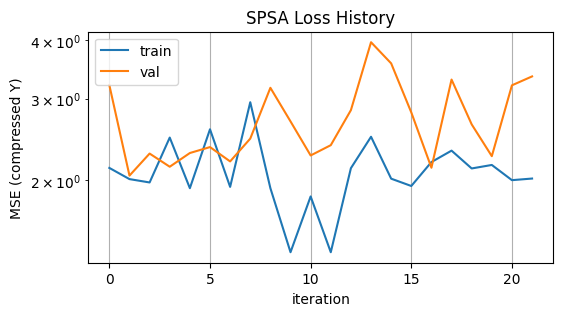

[SAVE] C:\qiskit-python\QFF2025\outputs\VQA\fig_true_pred_0.png


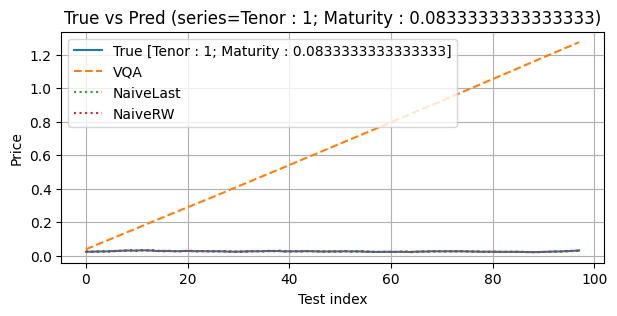

[SAVE] C:\qiskit-python\QFF2025\outputs\VQA\fig_true_pred_111.png


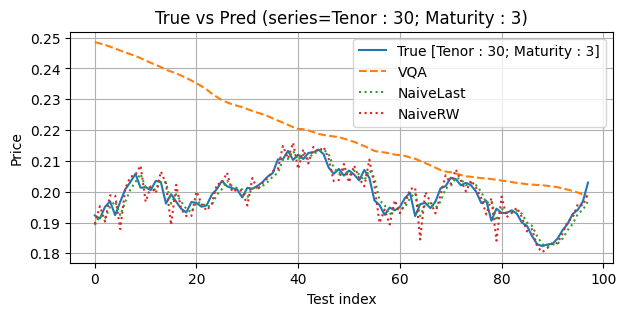

[SAVE] C:\qiskit-python\QFF2025\outputs\VQA\fig_true_pred_223.png


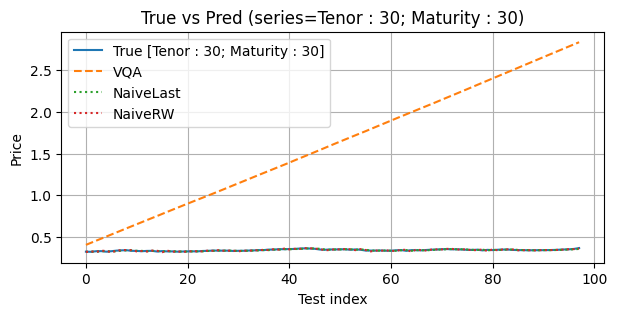

[SAVE] C:\qiskit-python\QFF2025\outputs\VQA\fig_parity.png


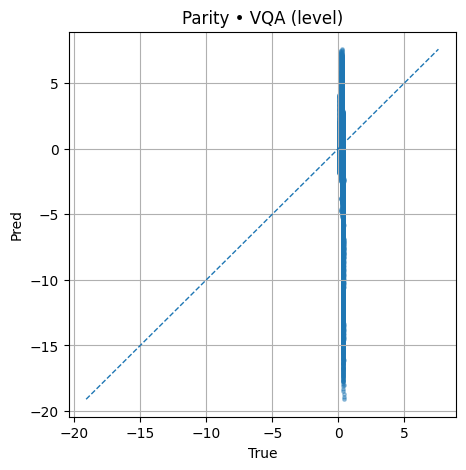

[SAVE] C:\qiskit-python\QFF2025\outputs\VQA\fig_err_hist.png


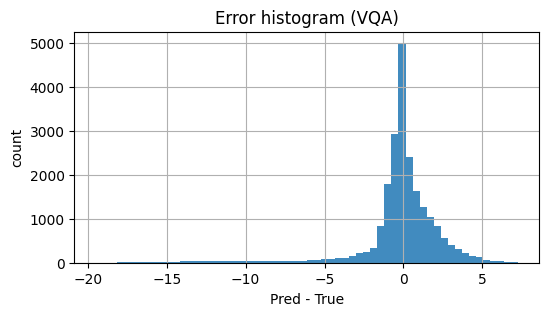

[SAVE] C:\qiskit-python\QFF2025\outputs\VQA\fig_rmse_heatmap.png


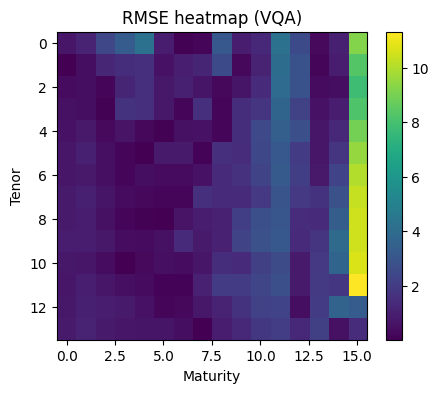

[SAVE] C:\qiskit-python\QFF2025\outputs\VQA\table_errors_grid.csv
[SAVE] C:\qiskit-python\QFF2025\outputs\VQA\fig_rbf_overlay.png


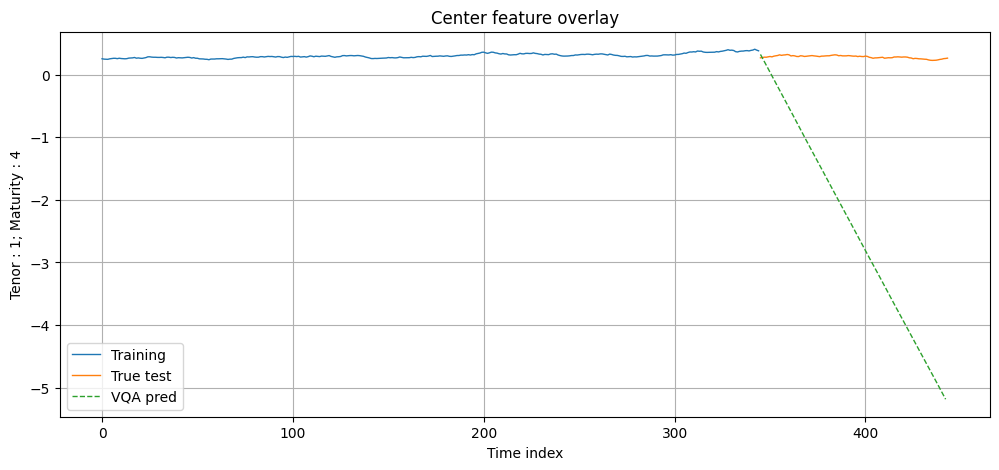

[SAVE] C:\qiskit-python\QFF2025\outputs\VQA\fig_circuit.png


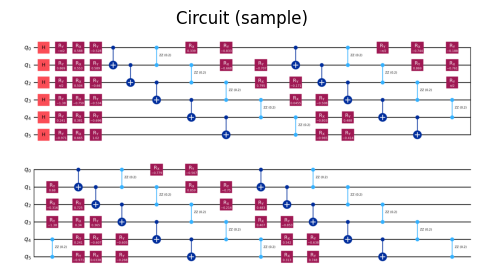

[SAVE] C:\qiskit-python\QFF2025\outputs\VQA\table_circuit_stats.csv


In [8]:
# =========================
# 3) 可視化（保存＋Notebook表示）
# =========================
assert 'artifacts' in globals(), "先に #2 セルを実行して artifacts を作ってください"
hist = artifacts["hist"]
Y_te = artifacts["Y_te"]; Y_hat_te = artifacts["Y_hat_te"]
Y_te_baselines = artifacts["Y_te_baselines"]
prices = artifacts["prices"]; series_names = artifacts["series_names"]
parts = artifacts["parts"]; tr = artifacts["tr"]; vqa = artifacts["vqa"]; head = artifacts.get("head")
Xb_tr = artifacts["Xb_tr"]

# ★ safety: head がない状態（前セルが途中で止まった履歴が残った等）なら復元
if head is None:
    from sklearn.linear_model import Ridge
    Z_tr = vqa.predict_batch(Xb_tr)
    Yb_tr = artifacts.get("Yb_tr")
    if Yb_tr is None:
        raise RuntimeError("head が見つからず、Yb_tr も保存されていないため復元できません。#2 セルを再実行してください。")
    head = Ridge(alpha=1e-6, fit_intercept=True).fit(Z_tr, Yb_tr)

# 1) 学習曲線
plt.figure(figsize=(6,3))
plt.plot(hist["train"], label="train")
if len(hist["val"])>0 and not np.isnan(hist["val"]).all():
    plt.plot(hist["val"], label="val")
plt.yscale('log'); plt.xlabel('iteration'); plt.ylabel('MSE (compressed Y)')
plt.title('SPSA Loss History'); plt.legend(); plt.grid(True)
savefig_show("fig_spsa_history.png")

# 2) 代表 3 シリーズの True vs Pred
M = Y_te.shape[1]
sel = np.linspace(0, M-1, num=min(3, M), dtype=int)
t = np.arange(Y_te.shape[0])
for idx in sel:
    plt.figure(figsize=(7,3))
    plt.plot(t, Y_te[:, idx], label=f"True [{series_names[idx]}]")
    plt.plot(t, Y_hat_te[:, idx], '--', label="VQA")
    for name, Yb in Y_te_baselines.items():
        plt.plot(t, Yb[:, idx], ':', label=name)
    plt.title(f"True vs Pred (series={series_names[idx]})"); plt.xlabel("Test index"); plt.ylabel("Price")
    plt.grid(True); plt.legend()
    savefig_show(f"fig_true_pred_{idx}.png")

# 3) パリティ
parity_plot(Y_te, Y_hat_te, title="Parity • VQA (level)")
savefig_show("fig_parity.png")

# 4) 誤差ヒスト
err = (Y_hat_te - Y_te).ravel()
plt.figure(figsize=(6,3)); plt.hist(err, bins=60, alpha=0.85)
plt.title("Error histogram (VQA)"); plt.xlabel("Pred - True"); plt.ylabel("count"); plt.grid(True)
savefig_show("fig_err_hist.png")

# 5) RMSE ヒートマップ
rmse_heatmap(Y_te, Y_hat_te, series_names)

# 6) RBF風オーバレイ（中央セル）
X_train_last = parts["train"][0]  # (Ntr, M) 最後の1日の断面
X_test_last  = parts["test"][0]   # (Nte, M)
center_idx = X_test_last.shape[1] // 2
overlay_series(X_train_last, X_test_last, {"VQA": Y_hat_te}, center_idx, series_names)

# 7) 回路図と統計
visualize_circuit_and_stats(vqa, xbar_sample=Xb_tr[0])
